In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
import PIL
from PIL import Image


# torch
import torch

# key_dynam
from key_dynam.utils.utils import get_project_root, load_yaml
from key_dynam.dataset.drake_sim_episode_reader import DrakeSimEpisodeReader
from key_dynam.utils import transform_utils
from key_dynam.utils import drake_image_utils
from key_dynam.dense_correspondence.descriptor_net import sample_descriptors, PrecomputedDescriptorNet

# pdc
from dense_correspondence.dataset.dynamic_drake_sim_dataset import DynamicDrakeSimDataset
from dense_correspondence.correspondence_tools.correspondence_finder import reproject_pixels
from dense_correspondence.correspondence_tools import correspondence_plotter
from dense_correspondence.correspondence_tools.correspondence_finder import compute_correspondence_data, pad_correspondence_data
from dense_correspondence_manipulation.utils.utils import getDenseCorrespondenceSourceDir, set_cuda_visible_devices
import dense_correspondence.loss_functions.utils as loss_utils
import dense_correspondence_manipulation.utils.utils as pdc_utils
import dense_correspondence_manipulation.utils.visualization as vis_utils
from dense_correspondence.network.predict import get_argmax_l2


GPU_LIST = [1]
set_cuda_visible_devices(GPU_LIST)

setting CUDA_VISIBLE_DEVICES =  1,


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: _DrakeImportWarning: 
You may have already (directly or indirectly) imported `torch` which uses
`RTLD_GLOBAL`. Using `RTLD_GLOBAL` may cause symbol collisions which manifest
themselves in bugs like "free(): invalid pointer". Please consider importing
`pydrake` (and related C++-wrapped libraries like `cv2`, `open3d`, etc.)
*before* importing `torch`. For more details, see:
https://github.com/pytorch/pytorch/issues/3059#issuecomment-534676459



## Load Dataset

In [3]:
DATASET_NAME = "2019-11-26-00-03-48-223155"
DATASET_NAME = "top_down_same_view"
DATASET_NAME = "top_down_rotated"

dataset_root = os.path.join(get_project_root(), "data/dev/experiments/05/data", DATASET_NAME)

multi_episode_dict = DrakeSimEpisodeReader.load_dataset(dataset_root)
# make pdc dataset now

# placeholder for now
config_file = os.path.join(getDenseCorrespondenceSourceDir(), 
                           'config/dense_correspondence/global/drake_sim_dynamic.yaml')
config = load_yaml(config_file)
dataset = DynamicDrakeSimDataset(config, multi_episode_dict, phase="train")
dataset_valid = DynamicDrakeSimDataset(config, multi_episode_dict, phase="valid")

episode_name = list(multi_episode_dict.keys())[0]
print("episode name:", episode_name)

idx = 0
episode = multi_episode_dict[episode_name]
print("episode._non_image_data.keys()", episode._non_image_data.keys())

camera_names = list(episode.camera_names)
camera_name_a = camera_names[0]
camera_name_b = camera_names[1]

global_config = load_yaml(os.path.join(get_project_root(), 'experiments/05/config.yaml'))

episode name: 2019-12-03-22-49-25-126451_idx_0
episode._non_image_data.keys() dict_keys(['name', 'config', 'trajectory', 'metadata', 'hdf5_file'])


## Load Network

In [4]:
# load network

# model_name = "2019-12-03-21-25-46-128603_top_down_same_view"
# model_name = "2019-12-03-22-51-17-805212_top_down_rotated"
# model_name = "2019-12-03-23-40-30-486661_top_down_rotated_sigma_5"
model_name = "2019-12-04-01-32-12-010393_top_down_rotated_sigma_5"
network_folder = os.path.join(get_project_root(), "data/dev/experiments/05/trained_models", model_name)

epoch = 155
model_file = os.path.join(network_folder, "net_dy_epoch_%d_iter_0_model.pth" %(epoch))
model = torch.load(model_file)
model.cuda()
model = model.eval()

## Use DescriptorLocalization Network

device:
img_mask.shape torch.Size([480, 640])
ref_descriptors.shape torch.Size([16, 3])
ref_descriptors_indices.shape torch.Size([16, 2])
type(pdn._ref_descriptors) <class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([[ 2.6157,  2.5589,  1.5453],
        [ 2.9860,  4.0615,  3.8432],
        [ 1.7415,  0.6547,  0.0876],
        [ 0.0732, -2.1668, -0.9685],
        [-0.8026, -0.0936, -1.4007],
        [-4.0833, -5.4361, -0.9291],
        [-2.3094,  0.4955, -1.5456],
        [ 2.6787,  3.0843,  2.0220],
        [ 4.0622,  0.6837,  2.5780],
        [-3.1863,  2.1393, -0.2868],
        [-1.6014, -0.8349, -1.7747],
        [-5.5655, -0.6321, -1.6751],
        [-5.5399, -1.5700, -1.9177],
        [ 2.3993, -1.1781,  0.7104],
        [-0.5858, -2.2084, -1.3150],
        [ 3.5390,  2.7259,  2.6483]], device='cuda:0')


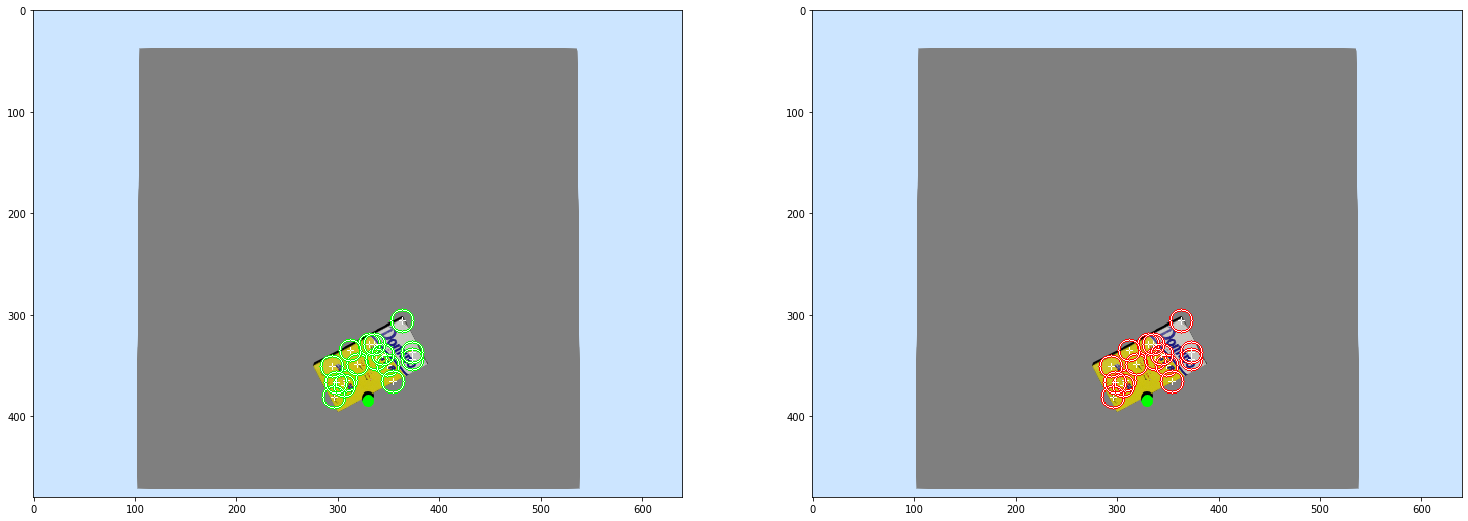

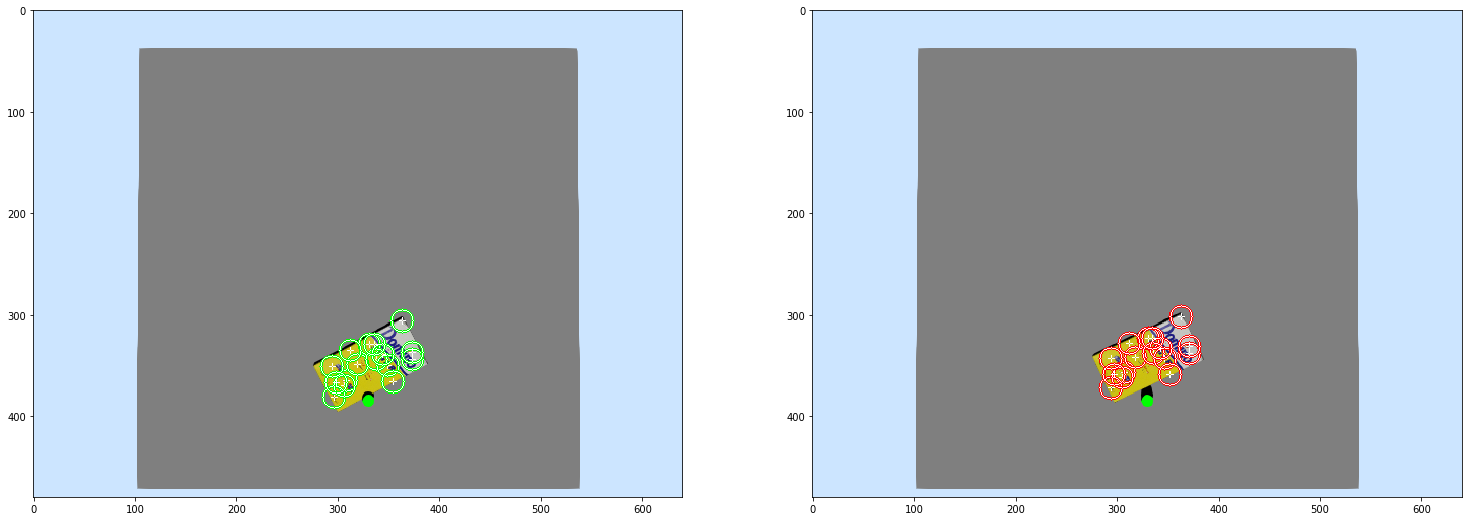

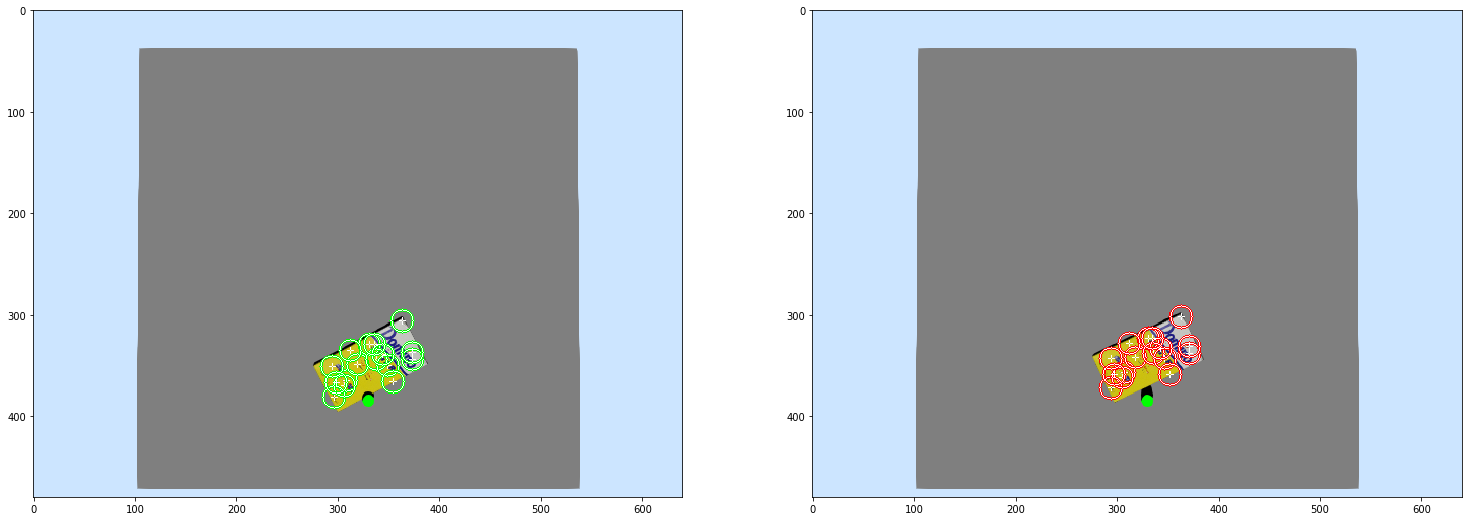

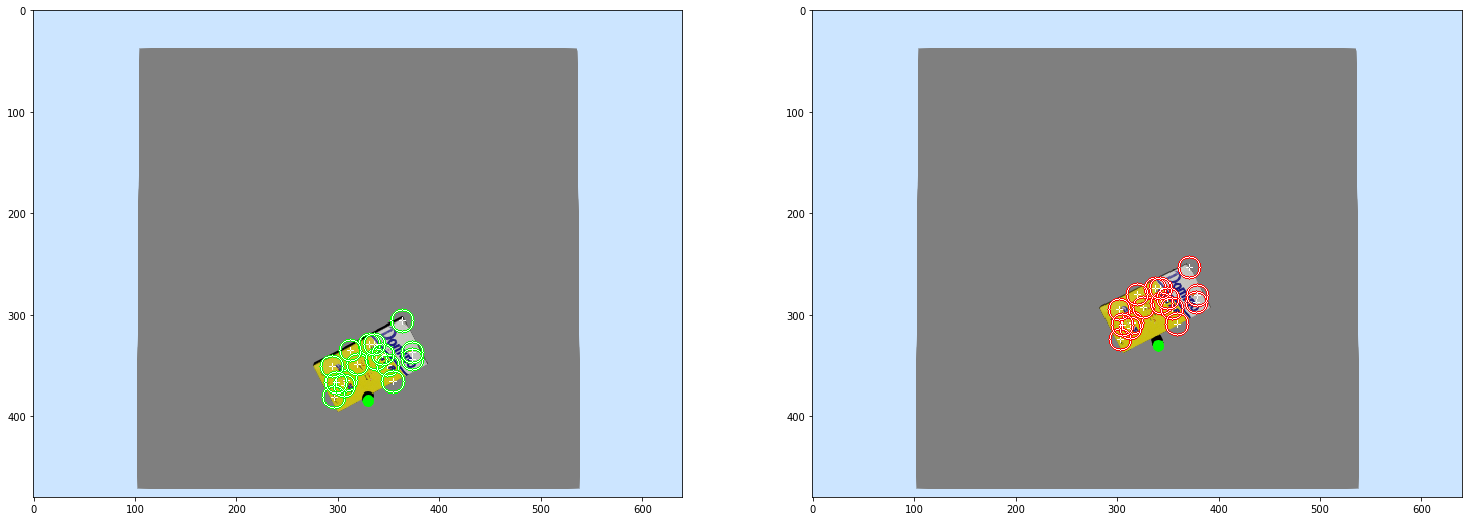

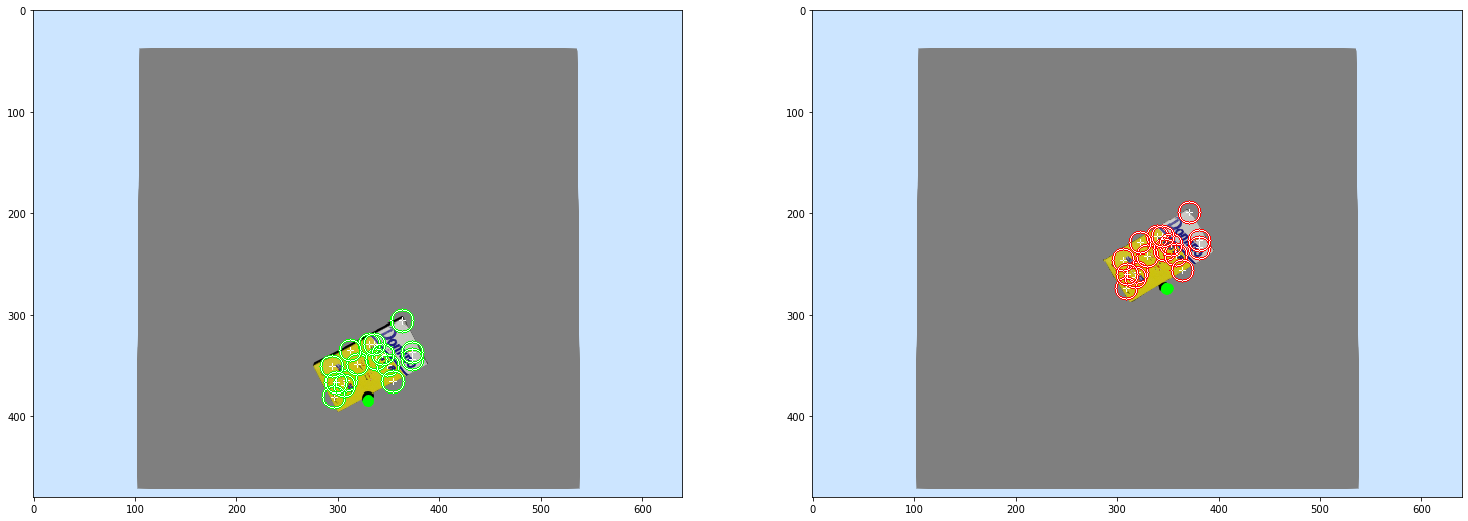

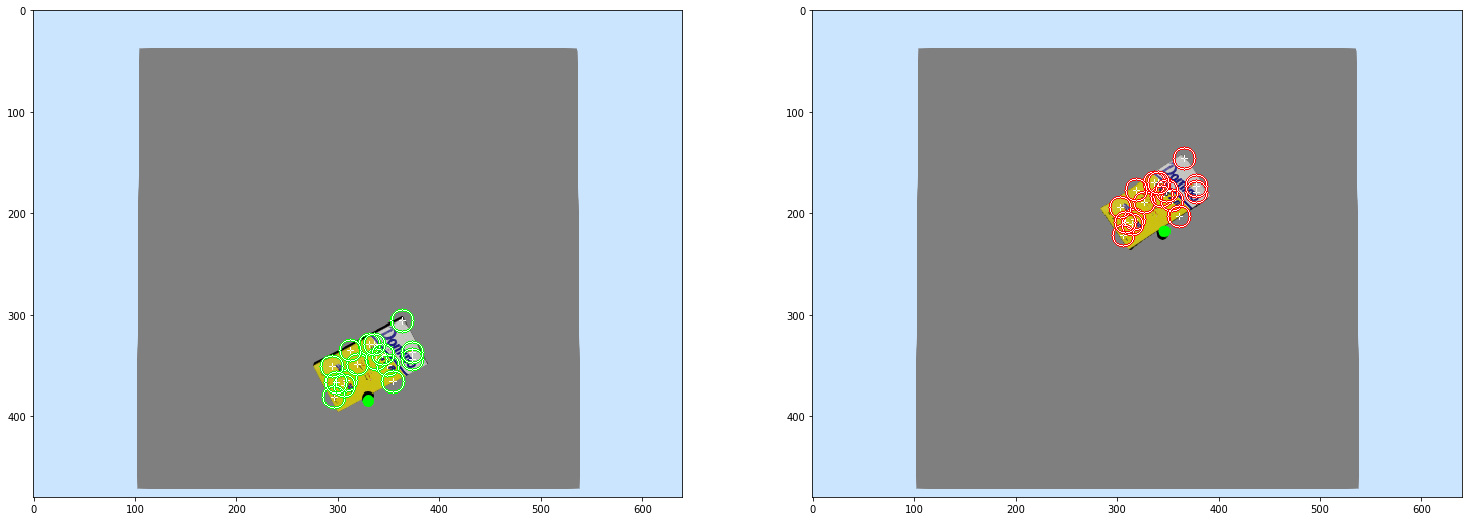

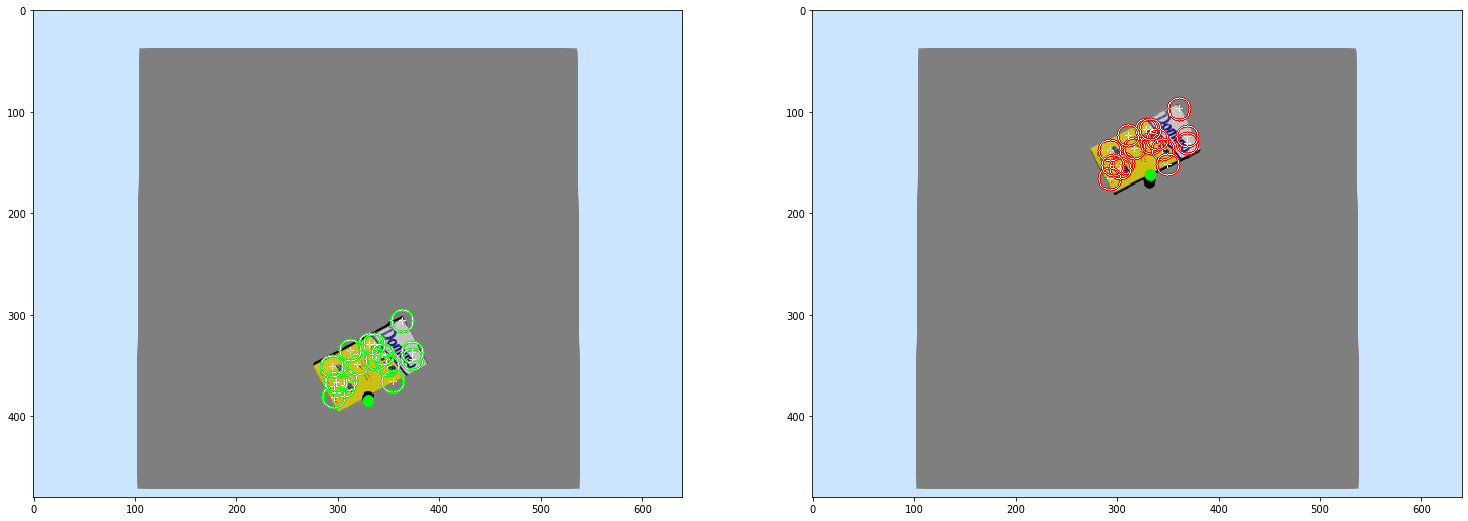

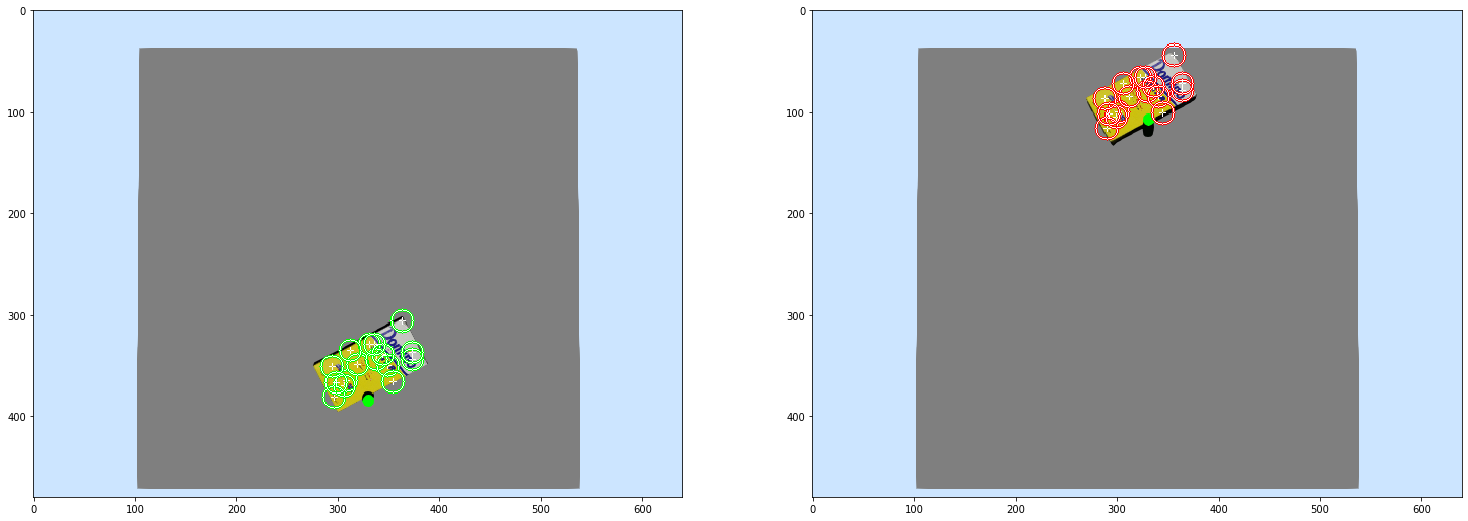

In [6]:
pdc_utils.reset_random_seed()
device = next(model.parameters()).device

print("device:")
idx = 0
idx_step = 5

MODEL_ENABLED = True
DATA_TYPE = "valid"
NUM_REF_DESCRIPTORS = 16

sz = 2
num_rows = 1
num_cols = 2
figsize = (6.4*sz*num_cols, 4.8*sz*num_rows)

with torch.no_grad():

    # indices
    b = 0
    n = 10

    data = None
    dataset_tmp = None
    if DATA_TYPE == "train":
        dataset_tmp = dataset
    elif DATA_TYPE == "valid":
        dataset_tmp = dataset_valid
        
    
    data = dataset_tmp._getitem(episode, 
                                idx,
                                camera_name_a=camera_name_a, 
                                camera_name_b=camera_name_b)
    
    data_a = data['data_a']
    rgb_tensor_a = data_a['rgb_tensor'].to(device).unsqueeze(0)
    rgb_tensor_b = data['data_b']['rgb_tensor'].to(device).unsqueeze(0)
    rgb_a = data_a['rgb']
    uv_a = data['matches']['uv_a'].unsqueeze(0).to(device) # [B, 2, N]
    uv_b = data['matches']['uv_b'].unsqueeze(0).to(device) # [B, 2, N]
    valid = data['matches']['valid'].unsqueeze(0).to(device) # [B, N]

    # [1,D,H,W]
    out_a = model.forward(rgb_tensor_a)
    des_img_a = out_a['descriptor_image']
    
    # sample reference descriptors
    img_mask = torch.tensor(data['data_a']['mask']).to(device)
    print("img_mask.shape", img_mask.shape)
    ref_descriptors_dict = sample_descriptors(des_img_a.squeeze(), img_mask, NUM_REF_DESCRIPTORS)
    
    ref_descriptors = ref_descriptors_dict['descriptors']
    ref_descriptors_indices = ref_descriptors_dict['indices']
    
    print("ref_descriptors.shape", ref_descriptors.shape)
    print("ref_descriptors_indices.shape", ref_descriptors_indices.shape)

    
#     raise ValueError("TEST")
    
#     # [B,N,D]
#     des_a = pdc_utils.index_into_batch_image_tensor(des_img_a, uv_a).permute([0,2,1])
#     des_a_ref = des_a[b,n,:].unsqueeze(0).unsqueeze(0)
    
#     # [1,1,D]
#     uv_a_ref = uv_a.permute([0,2,1])[b,n,:].unsqueeze(0).unsqueeze(0)
    

    # make PrecomputeDescriptorNet
    pdn = PrecomputedDescriptorNet(global_config)
    pdn._ref_descriptors.data = ref_descriptors
    
    
    print("type(pdn._ref_descriptors)", type(pdn._ref_descriptors))
    print(pdn._ref_descriptors)
    
    
    
    

    episode.length    
    for i in range(100):
        idx_cur = i*idx_step
        
        if idx_cur >= episode.length:
            break
        
        data = dataset_tmp._getitem(episode, 
                                idx_cur,
                                camera_name_a=camera_name_a, 
                                camera_name_b=camera_name_b)
        
        rgb = data['data_a']['rgb']
        rgb_tensor = data['data_a']['rgb_tensor'].unsqueeze(0).to(device)
        out = model.forward(rgb_tensor)
        des_img = out['descriptor_image']
        
        
        
        out = pdn.forward_descriptor_image(des_img)
        
#         print("des_img.shape", des_img.shape)
#         print("out.keys()", out.keys())
#         print("out['best_match_dict']['indices'].shape", out['best_match_dict']['indices'].shape)
        
        
        # [N, 2]
        best_match_indices = out['best_match_dict']['indices'].squeeze()


        # draw reference image
        label_color = [0, 255, 0]
        rgb_a_wr = np.copy(rgb_a)
        vis_utils.draw_reticles(rgb_a_wr,
                                ref_descriptors_indices[:, 0],
                                ref_descriptors_indices[:, 1],
                                label_color)
        
        # draw target image
        label_color = [255,0,0]
        rgb_wr = np.copy(rgb)
        vis_utils.draw_reticles(rgb_wr,
                               best_match_indices[:, 0],
                               best_match_indices[:, 1],
                               label_color)
        
        
        figname = "target idx: %d" %(idx_cur)
        fig = plt.figure(figname, figsize=figsize)
        axes = fig.subplots(num_rows, num_cols, squeeze=False)
        axes[0,0].imshow(rgb_a_wr)
        axes[0,1].imshow(rgb_wr)
        
        
        
        
        